# 在不同的联邦任务上进行联邦学习

这一节主要介绍如何在不同的联邦任务上测试算法。因此，这里简要分析数据异质性的种类和程度对fedavg的影响。

## 生成不同数据划分的联邦任务 

In [ ]:
import flgo
import flgo.benchmark.mnist_classification as mnist
import flgo.algorithm.fedavg as fedavg
import os

config_iid = {'benchmark':{'name':'flgo.benchmark.mnist_classification'},'partitioner':{'name': 'IIDPartitioner','para':{'num_clients':100}}}
config_div01 = {'benchmark':{'name':'flgo.benchmark.mnist_classification'},'partitioner':{'name': 'DiversityPartitioner','para':{'num_clients':100, 'diversity':0.1}}}
config_div05 = {'benchmark':{'name':'flgo.benchmark.mnist_classification'},'partitioner':{'name': 'DiversityPartitioner','para':{'num_clients':100, 'diversity':0.5}}}
config_div09 = {'benchmark':{'name':'flgo.benchmark.mnist_classification'},'partitioner':{'name': 'DiversityPartitioner','para':{'num_clients':100, 'diversity':0.9}}}
config_dir01 = {'benchmark':{'name':'flgo.benchmark.mnist_classification'},'partitioner':{'name': 'DirichletPartitioner','para':{'num_clients':100, 'alpha':0.1}}}
config_dir10 = {'benchmark':{'name':'flgo.benchmark.mnist_classification'},'partitioner':{'name': 'DirichletPartitioner','para':{'num_clients':100, 'alpha':1.0}}}
config_dir50 = {'benchmark':{'name':'flgo.benchmark.mnist_classification'},'partitioner':{'name': 'DirichletPartitioner','para':{'num_clients':100, 'alpha':5.0}}}
task_dict = {
    './mnist_iid': config_iid,
    './mnist_div01': config_div01,
    './mnist_div05': config_div05,
    './mnist_div09': config_div09,
    './mnist_dir01': config_dir01,
    './mnist_dir10': config_dir10,
    './mnist_dir50': config_dir50,
}

for task in task_dict:
    if not os.path.exists(task):
        flgo.gen_task(task_dict[task], task)

## 使用fedavg在这些任务上用同组参数训练

通过flgo.init函数设置不同任务上的运行器（runner）并启动

In [ ]:
import flgo.algorithm.fedavg as fedavg
option = {'gpu':0, 'num_rounds':50, 'num_epochs':1, 'learning_rate':0.1, 'batch_size':64, 'eval_interval':10}
runners = [flgo.init(task, fedavg, option) for task in task_dict]
for runner in runners:
    runner.run()

## 测试结果 - 数据异质性对联邦算法FedAvg的影响

首先使用flgo.experiment.analyzer.Selector读取跑出来的实验结果，然后通过matplotlib绘制出图像。

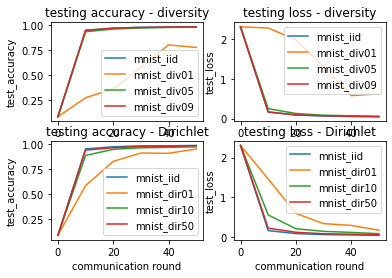

In [23]:
import flgo.experiment.analyzer as al
import matplotlib.pyplot as plt
div_recs = al.Selector({'task':[t for t in task_dict if 'iid' in t or 'div' in t], 'header':['fedavg']})

plt.subplot(221)
for task in div_recs.tasks:
    rec_list = div_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_accuracy'], label=task.split('/')[-1])
plt.title('testing accuracy - diversity')
plt.ylabel('test_accuracy')
plt.xlabel('communication round')
plt.legend()

plt.subplot(222)
for task in div_recs.tasks:
    rec_list = div_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_loss'], label=task.split('/')[-1])
plt.title('testing loss - diversity')
plt.ylabel('test_loss')
plt.xlabel('communication round')
plt.legend()

plt.subplot(223)
dir_recs = al.Selector({'task':[task for task in task_dict if 'iid' in task or 'dir' in task], 'header':['fedavg']})
for task in dir_recs.tasks:
    rec_list = dir_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_accuracy'], label=task.split('/')[-1])
plt.title('testing accuracy - Dirichlet')
plt.ylabel('test_accuracy')
plt.xlabel('communication round')
plt.legend()

plt.subplot(224)
dir_recs = al.Selector({'task':[task for task in task_dict if 'iid' in task or 'dir' in task], 'header':['fedavg']})
for task in dir_recs.tasks:
    rec_list = dir_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_loss'], label=task.split('/')[-1])
plt.title('testing loss - Dirichlet')
plt.ylabel('test_loss')
plt.xlabel('communication round')
plt.legend()
plt.show()

可以看到无论是diversity类型的数据异构划分，还是Dirichlet类型的数据异构划分，随着异构性的增加（对于Diversity来说指更小的diversity，对于Dicichlet来说指更大的alpha），fedavg在给定轮数内所能达到的精度均有所下降，初步反应了数据异质性对联邦学习的一个负面影响。该问题在Zhao等人于2018年上传的论文《Federated learning with non-IID data》被首次被指出。随后，许多算法被提出来提升各种non-IID设置下联邦算法的收敛速度和模型精度。